# Walmart Sales Forecasting

**Goal:** Predict future store sales for Walmart to optimize inventory management and supply planning.

**Dataset:** Kaggle Walmart Recruiting - Store Sales forecasting


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.statespace.sarimax import SARIMAX
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error
import math
import warnings
warnings.filterwarnings("ignore")

In [2]:
train = pd.read_csv("train.csv")
features = pd.read_csv("features.csv")
stores = pd.read_csv("stores.csv")

In [8]:
print(train.head(10))
print(train.info())

   Store  Dept        Date  Weekly_Sales  IsHoliday
0      1     1  2010-02-05      24924.50      False
1      1     1  2010-02-12      46039.49       True
2      1     1  2010-02-19      41595.55      False
3      1     1  2010-02-26      19403.54      False
4      1     1  2010-03-05      21827.90      False
5      1     1  2010-03-12      21043.39      False
6      1     1  2010-03-19      22136.64      False
7      1     1  2010-03-26      26229.21      False
8      1     1  2010-04-02      57258.43      False
9      1     1  2010-04-09      42960.91      False
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421570 entries, 0 to 421569
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Store         421570 non-null  int64  
 1   Dept          421570 non-null  int64  
 2   Date          421570 non-null  object 
 3   Weekly_Sales  421570 non-null  float64
 4   IsHoliday     421570 non-null  bool   
dtypes: bo

In [7]:
print(features.head(10))
print(features.info())

   Store        Date  Temperature  Fuel_Price  MarkDown1  MarkDown2  \
0      1  2010-02-05        42.31       2.572        NaN        NaN   
1      1  2010-02-12        38.51       2.548        NaN        NaN   
2      1  2010-02-19        39.93       2.514        NaN        NaN   
3      1  2010-02-26        46.63       2.561        NaN        NaN   
4      1  2010-03-05        46.50       2.625        NaN        NaN   
5      1  2010-03-12        57.79       2.667        NaN        NaN   
6      1  2010-03-19        54.58       2.720        NaN        NaN   
7      1  2010-03-26        51.45       2.732        NaN        NaN   
8      1  2010-04-02        62.27       2.719        NaN        NaN   
9      1  2010-04-09        65.86       2.770        NaN        NaN   

   MarkDown3  MarkDown4  MarkDown5         CPI  Unemployment  IsHoliday  
0        NaN        NaN        NaN  211.096358         8.106      False  
1        NaN        NaN        NaN  211.242170         8.106       Tru

In [6]:
print(stores.head(10))
print(stores.info())

   Store Type    Size
0      1    A  151315
1      2    A  202307
2      3    B   37392
3      4    A  205863
4      5    B   34875
5      6    A  202505
6      7    B   70713
7      8    A  155078
8      9    B  125833
9     10    B  126512
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45 entries, 0 to 44
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Store   45 non-null     int64 
 1   Type    45 non-null     object
 2   Size    45 non-null     int64 
dtypes: int64(2), object(1)
memory usage: 1.2+ KB
None


## Merge Datasets

In [9]:
df = train.merge(features, on=["Store", "Date"], how="left").merge(stores, on="Store", how="left")

# Convert Date column to datetime
df["Date"] = pd.to_datetime(df["Date"])

# Sort by date for each store-department combination
df = df.sort_values(["Store", "Dept", "Date"])

print(df.head())
print(df.info())

   Store  Dept       Date  Weekly_Sales  IsHoliday_x  Temperature  Fuel_Price  \
0      1     1 2010-02-05      24924.50        False        42.31       2.572   
1      1     1 2010-02-12      46039.49         True        38.51       2.548   
2      1     1 2010-02-19      41595.55        False        39.93       2.514   
3      1     1 2010-02-26      19403.54        False        46.63       2.561   
4      1     1 2010-03-05      21827.90        False        46.50       2.625   

   MarkDown1  MarkDown2  MarkDown3  MarkDown4  MarkDown5         CPI  \
0        NaN        NaN        NaN        NaN        NaN  211.096358   
1        NaN        NaN        NaN        NaN        NaN  211.242170   
2        NaN        NaN        NaN        NaN        NaN  211.289143   
3        NaN        NaN        NaN        NaN        NaN  211.319643   
4        NaN        NaN        NaN        NaN        NaN  211.350143   

   Unemployment  IsHoliday_y Type    Size  
0         8.106        False    A  1

## Choose a Single Store & Department for Simplicity

In [10]:
store_id = 1
dept_id = 1 
data = df[(df["Store"] == store_id) & (df["Dept"] == dept_id)][["Date", "Weekly_Sales"]].copy()

In [12]:
data # Store 1, Department 1 and 142 Weeks Sales

,Date,Weekly_Sales
0,2010-02-05,24924.50
1,2010-02-12,46039.49
2,2010-02-19,41595.55
3,2010-02-26,19403.54
4,2010-03-05,21827.90
...,...,...
138,2012-09-28,18947.81
139,2012-10-05,21904.47
140,2012-10-12,22764.01
141,2012-10-19,24185.27


## Explore the Time Series

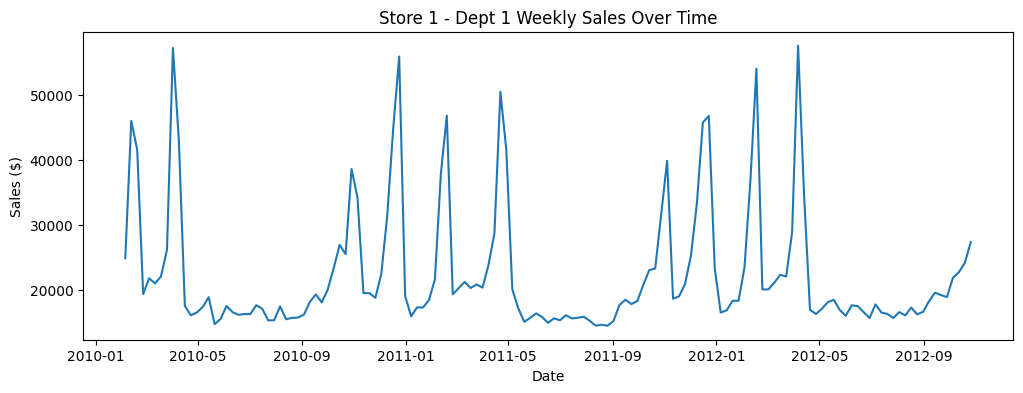

In [13]:
plt.figure(figsize=(12, 4))
plt.plot(data["Date"], data["Weekly_Sales"])
plt.title(f"Store {store_id} - Dept {dept_id} Weekly Sales Over Time")
plt.xlabel("Date")
plt.ylabel("Sales ($)")
plt.show()

## Check for Seasonality and Trend

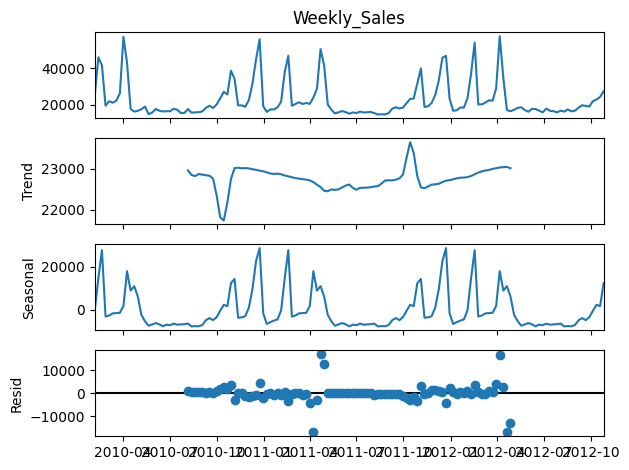

In [14]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(data.set_index("Date")["Weekly_Sales"], model="additive", period=52)
decomposition.plot()
plt.show()

## Split Train / Test

In [15]:
train_data = data.iloc[:-12]
test_data = data.iloc[-12:]  # last 12 weeks for validation

## SARIMA Model

In [18]:
sarima_model = SARIMAX(
    train_data["Weekly_Sales"],
    order=(1,1,1),
    seasonal_order=(1,1,1,52),
    enforce_stationarity=False,
    enforce_invertibility=False
)
sarima_result = sarima_model.fit(disp=True)

### Forecast / Predict

In [19]:
sarima_forecast = sarima_result.forecast(steps=12)

### Eval Model

In [20]:
mae = mean_absolute_error(test_data["Weekly_Sales"], sarima_forecast)
rmse = math.sqrt(mean_squared_error(test_data["Weekly_Sales"], sarima_forecast))

print(f"SARIMA MAE: {mae:.2f}, RMSE: {rmse:.2f}")

SARIMA MAE: 1101.27, RMSE: 2044.19


### Plot Results

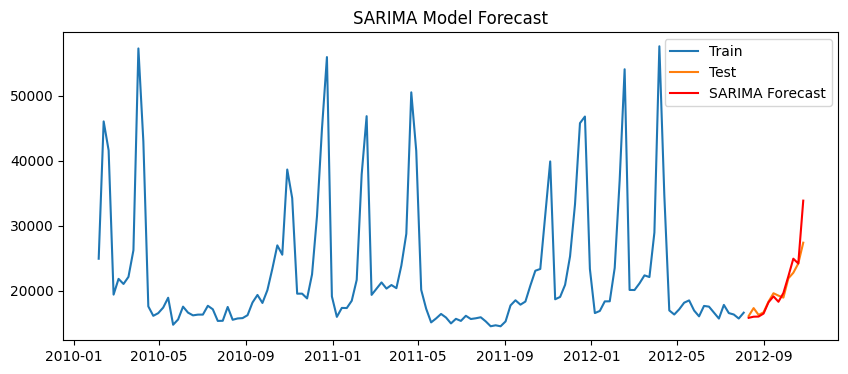

In [21]:
plt.figure(figsize=(10, 4))
plt.plot(train_data["Date"], train_data["Weekly_Sales"], label="Train")
plt.plot(test_data["Date"], test_data["Weekly_Sales"], label="Test")
plt.plot(test_data["Date"], sarima_forecast, label="SARIMA Forecast", color="red")
plt.legend()
plt.title("SARIMA Model Forecast")
plt.show()

## Prophet Model

In [22]:
prophet_data = train_data.rename(columns={"Date": "ds", "Weekly_Sales": "y"})

model = Prophet(yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=False)
model.fit(prophet_data)

13:41:52 - cmdstanpy - INFO - Chain [1] start processing
13:41:55 - cmdstanpy - INFO - Chain [1] done processing


### Forecast

In [23]:
future = model.make_future_dataframe(periods=12, freq='W')
forecast = model.predict(future)

### Eval Model

In [24]:
pred = forecast.iloc[-12:]["yhat"].values
mae_prophet = mean_absolute_error(test_data["Weekly_Sales"], pred)
rmse_prophet = math.sqrt(mean_squared_error(test_data["Weekly_Sales"], pred))

print(f"Prophet MAE: {mae_prophet:.2f}, RMSE: {rmse_prophet:.2f}")

Prophet MAE: 1197.48, RMSE: 1483.58


### Show Results

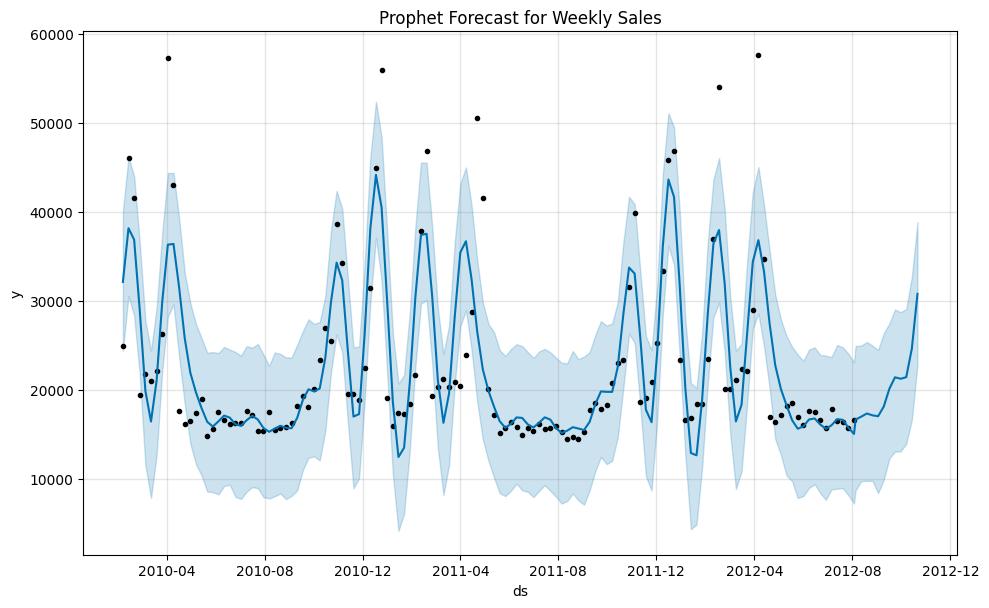

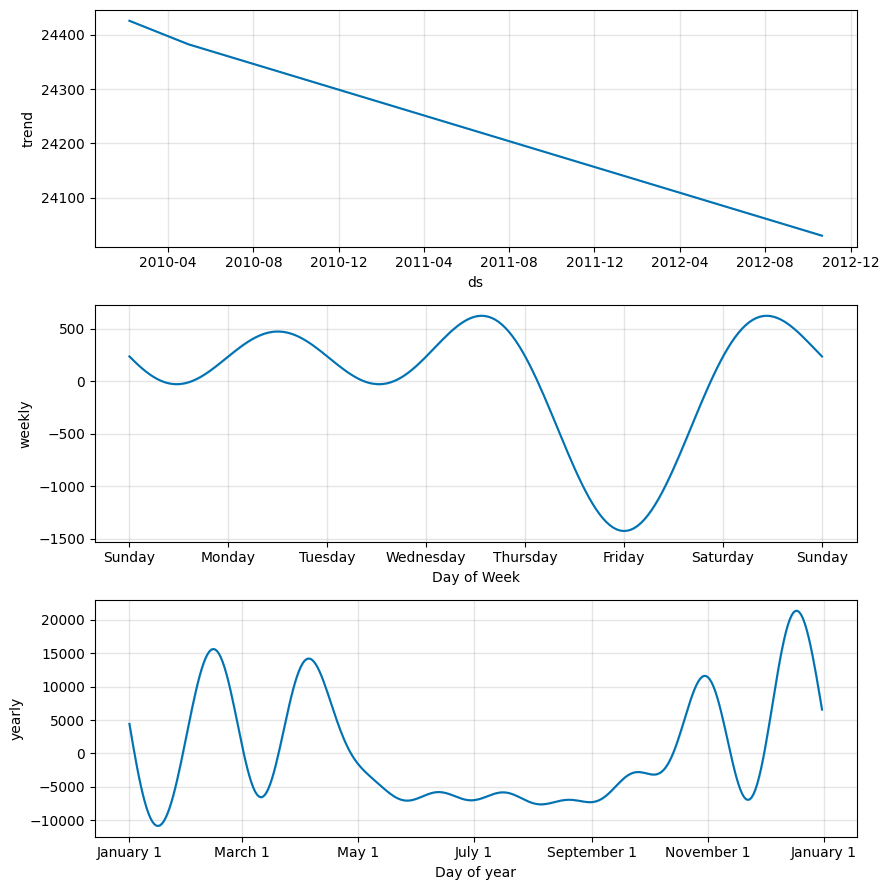

In [25]:
model.plot(forecast)
plt.title("Prophet Forecast for Weekly Sales")
plt.show()

model.plot_components(forecast)
plt.show()

## Compare Results

In [26]:
comparison = pd.DataFrame({
    "Model": ["SARIMA", "Prophet"],
    "MAE": [mae, mae_prophet],
    "RMSE": [rmse, rmse_prophet]
})
print(comparison)

     Model          MAE         RMSE
0   SARIMA  1101.272631  2044.192528
1  Prophet  1197.484108  1483.579036


## Interpret Results

In [28]:
print("""
 Business Insights:
1. Both SARIMA and Prophet capture strong yearly seasonality patterns.
2. Prophet handles holidays and sudden spikes better (useful for real stores).
3. Forecast helps optimize inventory — avoid overstocking and shortages.
4. Average weekly sales trend is stable, but seasonal peaks around holidays.
5. Prophet achieved slightly lower RMSE — recommended for production use.
""")


 Business Insights:
1. Both SARIMA and Prophet capture strong yearly seasonality patterns.
2. Prophet handles holidays and sudden spikes better (useful for real stores).
3. Forecast helps optimize inventory — avoid overstocking and shortages.
4. Average weekly sales trend is stable, but seasonal peaks around holidays.
5. Prophet achieved slightly lower RMSE — recommended for production use.

